In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
        batch_size = 128,
    )
    return agent

In [4]:
#safe learning   
l = 5.
step = 2000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"], action_lr=0.001, tau_lr=0.0001)
a.actor.load_weights('./saved_agent/self_trigger_split.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Instructions for updating:
Colocations handled automatically by placer.
Training for 2000000 steps ...
Interval 1 (0 steps performed)
  915/10000 [=>............................] - ETA: 5s - reward: 0.0050WARNING:tensorflow:From /Users/takeuchi_ibuki/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
10000/10000 [==============================] - 79s 8ms/step - reward: 0.0435
162 episodes - episode_reward: -9503.534 [-10000.118, 4.104] - loss: 0.021 - mean_absolute_error: 0.038 - mean_q: -0.109

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: 0.2359
280 episodes - episode_reward: -8491.565 [-10001.662, 37.299] - loss: 0.037 - mean_absolute_error: 0.136 - mean_q: 1.528

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 97s 10

10000/10000 [==============================] - 115s 12ms/step - reward: 0.3659
100 episodes - episode_reward: 36.570 [32.305, 39.019] - loss: 6.121 - mean_absolute_error: 0.619 - mean_q: 36.162

Interval 34 (330000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: 0.3493
100 episodes - episode_reward: 34.936 [19.203, 38.687] - loss: 5.773 - mean_absolute_error: 0.614 - mean_q: 34.505

Interval 35 (340000 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: 0.3696
100 episodes - episode_reward: 36.959 [22.661, 38.261] - loss: 5.320 - mean_absolute_error: 0.593 - mean_q: 32.873

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 120s 12ms/step - reward: 0.3811
100 episodes - episode_reward: 38.111 [37.030, 39.576] - loss: 4.819 - mean_absolute_error: 0.566 - mean_q: 31.289

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: 

10000/10000 [==============================] - 113s 11ms/step - reward: 0.4219
100 episodes - episode_reward: 42.196 [38.404, 49.513] - loss: 3.313 - mean_absolute_error: 0.454 - mean_q: 26.120

Interval 69 (680000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: 0.4807
104 episodes - episode_reward: -627.167 [-9996.368, 49.961] - loss: 3.351 - mean_absolute_error: 0.456 - mean_q: 26.146

Interval 70 (690000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: 0.4047
103 episodes - episode_reward: -446.102 [-9999.619, 49.978] - loss: 3.296 - mean_absolute_error: 0.450 - mean_q: 26.121

Interval 71 (700000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: 0.4451
100 episodes - episode_reward: 44.560 [38.171, 49.706] - loss: 3.297 - mean_absolute_error: 0.454 - mean_q: 26.175

Interval 72 (710000 steps performed)
10000/10000 [==============================] - 120s 12ms/step 

10000/10000 [==============================] - 137s 14ms/step - reward: -0.0902
2799 episodes - episode_reward: -10000.322 [-10001.157, -9999.393] - loss: 18.326 - mean_absolute_error: 0.771 - mean_q: 83.168

Interval 104 (1030000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -0.1467
2654 episodes - episode_reward: -10000.553 [-10001.180, -9999.378] - loss: 7.924 - mean_absolute_error: 0.426 - mean_q: 72.838

Interval 105 (1040000 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: 0.2240
660 episodes - episode_reward: -8905.713 [-10001.176, 41.337] - loss: 3.357 - mean_absolute_error: 0.344 - mean_q: 65.617

Interval 106 (1050000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: 0.4346
100 episodes - episode_reward: 43.442 [39.876, 49.602] - loss: 5.020 - mean_absolute_error: 0.497 - mean_q: 63.053

Interval 107 (1060000 steps performed)
10000/10000 [=================

10000/10000 [==============================] - 112s 11ms/step - reward: 0.4058
100 episodes - episode_reward: 40.596 [31.473, 48.925] - loss: 4.163 - mean_absolute_error: 0.519 - mean_q: 29.280

Interval 139 (1380000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: 0.4246
100 episodes - episode_reward: 42.414 [30.930, 49.303] - loss: 4.497 - mean_absolute_error: 0.530 - mean_q: 30.416

Interval 140 (1390000 steps performed)
10000/10000 [==============================] - 126s 13ms/step - reward: 0.2324
735 episodes - episode_reward: -9044.418 [-10001.249, 49.513] - loss: 4.492 - mean_absolute_error: 0.532 - mean_q: 30.514

Interval 141 (1400000 steps performed)
10000/10000 [==============================] - 119s 12ms/step - reward: 0.4641
124 episodes - episode_reward: -2059.427 [-10000.275, 49.784] - loss: 4.305 - mean_absolute_error: 0.524 - mean_q: 30.719

Interval 142 (1410000 steps performed)
10000/10000 [==============================] - 106

10000/10000 [==============================] - 113s 11ms/step - reward: 0.3922
100 episodes - episode_reward: 39.211 [29.052, 49.861] - loss: 4.683 - mean_absolute_error: 0.533 - mean_q: 30.918

Interval 174 (1730000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: 0.3915
100 episodes - episode_reward: 39.144 [25.980, 48.296] - loss: 4.487 - mean_absolute_error: 0.525 - mean_q: 30.085

Interval 175 (1740000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: 0.3731
100 episodes - episode_reward: 37.325 [25.620, 47.514] - loss: 4.260 - mean_absolute_error: 0.510 - mean_q: 29.549

Interval 176 (1750000 steps performed)
10000/10000 [==============================] - 126s 13ms/step - reward: 0.4043
100 episodes - episode_reward: 40.421 [33.073, 45.297] - loss: 4.088 - mean_absolute_error: 0.501 - mean_q: 28.987

Interval 177 (1760000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - 

ValueError: x and y must have same first dimension, but have shapes (2038478,) and (2029478,)

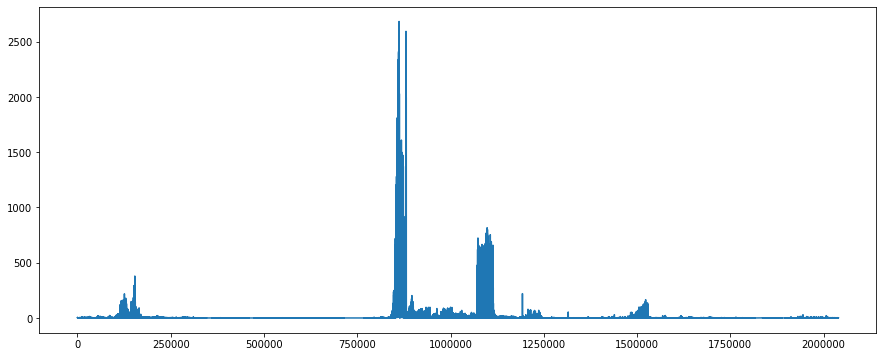

In [6]:
# gradient changing log
grads = np.array(a.gradient_log)
ma = moving_average(grads, 10000)
plt.figure(figsize=(15,6))
plt.plot(range(grads.shape[0]),grads)
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

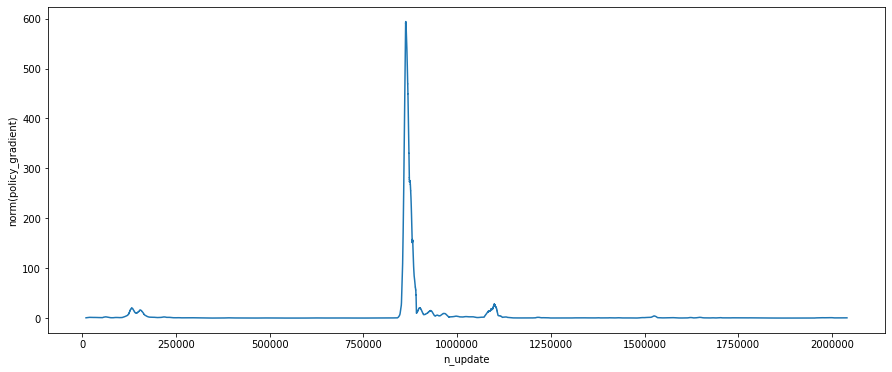

In [7]:
plt.figure(figsize=(15,6))
plt.plot(range(10000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

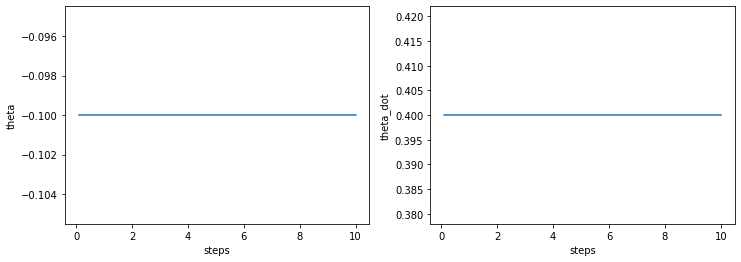

In [16]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
env.reset()
# env.state = np.array([-0.1, 0.4])
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

In [12]:
print(env.state)

[-0.1  0.4]


In [21]:
states = []
taus = []
high = np.array([np.pi, 8])
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

<IPython.core.display.Javascript object>


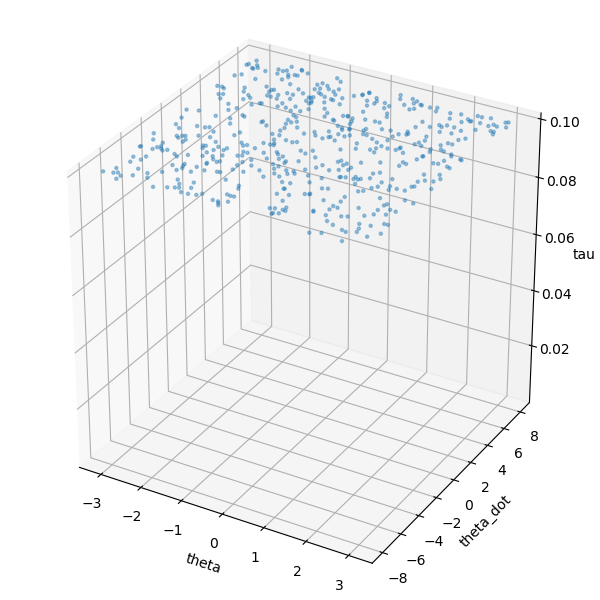

In [22]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

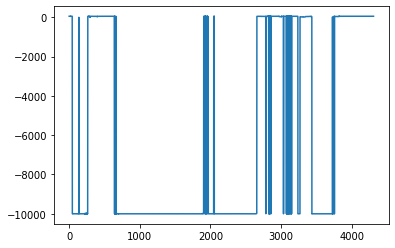

In [28]:
plt.plot(out.history['episode_reward'])

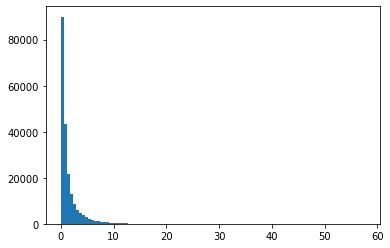

In [31]:
plt.hist(grads, bins=100)
plt.show()

In [37]:
mem = a.memory.sample(50000)
states = []
actions = []
for m in mem:
    states.append(m.state0[0])
    actions.append(m.action)
states = np.array(states)
actions = np.array(actions)

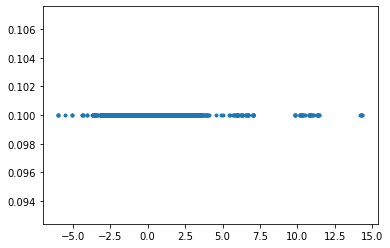

In [39]:
plt.scatter(states[:,1], actions[:, 1], marker='.')